In [4]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from ultralytics import YOLO
import math
import time

# ========== Threshold Settings ==========
THRESHOLD_AVG_INTENSITY = 180  # Threshold for average intensity (bleachness)
THRESHOLD_STD_INTENSITY = 65   # Threshold for standard deviation (roughness)

# ========== Paths and Setup ==========
# Define input directory for test images and output directory for results
relevant_path    = "input_images"
results_path     = "output"
model_path       = "wheat_kernel_FDK_Detector.pt"

# Create output directory if it doesn't exist
os.makedirs(results_path, exist_ok=True)

# Collect image filenames with supported extensions
included_extensions = ['jpg','jpeg']
file_names = [
    fn for fn in os.listdir(relevant_path)
    if any(fn.lower().endswith(ext) for ext in included_extensions)
]

# Load YOLO model once
model = YOLO(model_path)

# ========== Helper Functions ==========

def smooth_profile(profile, window_size=9):
    """Apply moving average smoothing to an intensity profile."""
    if window_size < 2: return profile
    return np.convolve(profile, np.ones(window_size)/window_size, mode='valid')

def calculate_profile_length(positions, intensities):
    """Calculate arc length of the profile curve based on X and intensity values."""
    return sum(
        math.hypot(positions[i]-positions[i-1], intensities[i]-intensities[i-1])
        for i in range(1, len(positions))
    )

def classify_kernel_by_profile_ratio(kernel):
    """Classify kernel as 'With Crease' or 'Without Crease' based on profile roughness."""
    # Convert to grayscale and enhance contrast
    gray    = cv2.cvtColor(kernel, cv2.COLOR_RGB2GRAY)
    blurred = cv2.medianBlur(gray, 5)
    clahe   = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced= clahe.apply(blurred)
    _, mask = cv2.threshold(enhanced, 10, 255, cv2.THRESH_BINARY)

    # Select profile scan lines and crop 40% width region (30% to 70%)
    h, w = enhanced.shape
    rows_y      = [int(h*r) for r in (0.4, 0.5, 0.6)]
    left_crop   = int(0.3*w)
    right_crop  = int(0.7*w)
    scan_length = right_crop - left_crop

    # Extract intensity values along each scan line inside the mask
    profiles, positions = [], []
    for y in rows_y:
        ri = enhanced[y, left_crop:right_crop]
        rm = mask[y,    left_crop:right_crop]
        valid = ri[rm>0]
        pos   = np.where(rm>0)[0] + left_crop
        if len(valid)>0:
            profiles.append(valid)
            positions.append(pos)

    if len(profiles) < 3:
        return "Unclassified", 0

    # Average the three profiles and compute the profile length ratio
    min_len = min(map(len, profiles))
    profiles = [p[:min_len] for p in profiles]
    pos      = positions[0][:min_len]
    avg_profile = np.mean(profiles, axis=0)
    smooth = smooth_profile(avg_profile)
    pos    = pos[:len(smooth)]

    length_ratio = calculate_profile_length(pos, smooth) / scan_length
    return ("With Crease" if length_ratio > 1.65 else "Without Crease"), length_ratio

def rotate_kernel(kernel):
    """Rotate kernel to align horizontally based on its fitted ellipse orientation."""
    gray = cv2.cvtColor(kernel, cv2.COLOR_RGB2GRAY)
    _,thresh = cv2.threshold(gray,50,255,cv2.THRESH_BINARY)
    contours,_ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return kernel
    cnt = max(contours, key=cv2.contourArea)
    if len(cnt) < 5: return kernel
    ellipse = cv2.fitEllipse(cnt)
    angle = ellipse[2] if ellipse[2] <= 90 else ellipse[2] - 180
    center = (kernel.shape[1]//2, kernel.shape[0]//2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(kernel, M, (kernel.shape[1], kernel.shape[0]),
                          borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

def save_kernel_grid(kernels, save_path, grid_size=(6,7), cell_size=(100,100)):
    """Save grid image of kernels to a file."""
    rows, cols = grid_size
    grid = np.ones((rows*cell_size[0], cols*cell_size[1], 3), dtype=np.uint8)*255
    for idx, kernel in enumerate(kernels[:rows*cols]):
        r, c = divmod(idx, cols)
        resized = cv2.resize(kernel, cell_size)
        grid[r*cell_size[0]:(r+1)*cell_size[0],
             c*cell_size[1]:(c+1)*cell_size[1]] = resized
    # Save using OpenCV
    cv2.imwrite(save_path, cv2.cvtColor(grid, cv2.COLOR_RGB2BGR))

# ========== Summary Trackers ==========
pct_avg_list       = []  # % kernels with avg intensity > 180
pct_std_list       = []  # % kernels with std intensity > 65
noncrease_pct_list = []  # % of kernels classified as "Without Crease"
num_list           = []  # Total number of kernels per image

# ========== Main Image Loop ==========
for fn in file_names:
    print(f"Processing {fn} -- {time.ctime()}")
    image_path = os.path.join(relevant_path, fn)
    img_name   = os.path.splitext(fn)[0]
    
    # Model prediction
    results = model.predict(image_path, conf=0.90, iou=0.4)
    orig    = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    # Extract cropped kernels from mask polygons
    kernel_list = []
    for r in results:
        for mask in r.masks.xy:
            mask_img = np.zeros(orig.shape[:2],dtype=np.uint8)
            pts = np.array(mask, np.int32)
            cv2.fillPoly(mask_img, [pts], 255)
            cropped = cv2.bitwise_and(orig, orig, mask=mask_img)[
                      cv2.boundingRect(pts)[1] : cv2.boundingRect(pts)[1]+cv2.boundingRect(pts)[3],
                      cv2.boundingRect(pts)[0] : cv2.boundingRect(pts)[0]+cv2.boundingRect(pts)[2]
            ]
            kernel_list.append(cropped)

    # Rotate and classify all kernels
    rotated = [rotate_kernel(k) for k in kernel_list]
    with_crease   = []
    without_crease= []
    for k in rotated:
        cls, _ = classify_kernel_by_profile_ratio(k)
        if cls=="With Crease":   with_crease.append(k)
        elif cls=="Without Crease": without_crease.append(k)

    # Save grid images of classified kernels
    save_kernel_grid(with_crease,
        os.path.join(results_path + "/images", f"{img_name}_with_crease_grid.jpg"))
    save_kernel_grid(without_crease,
        os.path.join(results_path + "/images", f"{img_name}_without_crease_grid.jpg"))

    # ========== Extract RGB Stats and Label Image ==========
    df_stats = []
    labeled = orig.copy()
    counter = 1
    for r in results:
        for mask, score in zip(r.masks.xy, r.boxes.conf):
            if score < 0.90: continue
            mask_img = np.zeros(labeled.shape[:2],dtype=np.uint8)
            pts = np.array(mask, np.int32)
            cv2.fillPoly(mask_img, [pts], 255)
            pixels = cv2.bitwise_and(labeled, labeled, mask=mask_img)[mask_img>0]
            mean_vals = pixels.mean(axis=0)
            std_vals  = pixels.std(axis=0)
            df_stats.append({
                'Plate_Name': img_name,
                'Kernel_ID': counter,
                'Average_Intensity': round(mean_vals.mean()),
                'Std_Intensity': round(std_vals.mean())
            })
            M = cv2.moments(pts)
            if M["m00"]!=0:
                cX = int(M["m10"]/M["m00"])
                cY = int(M["m01"]/M["m00"])
                cv2.putText(labeled, str(counter), (cX,cY),
                            cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,255), 12)
            counter += 1

    # Save labeled image and per-kernel statistics
    df = pd.DataFrame(df_stats)
    df.to_csv(os.path.join(results_path + "/individual_kernels_csv", f"{img_name}_avg.csv"), index=False)
    cv2.imwrite(os.path.join(results_path + "/images", f"{img_name}_labeled.jpg"),
                cv2.cvtColor(labeled, cv2.COLOR_RGB2BGR))

    # ========== Calculate Summary Metrics ==========
    avg_vals = df["Average_Intensity"].values
    std_vals = df["Std_Intensity"].values

    noncrease = len(without_crease) / max(len(rotated),1) * 100
    ncrease   = len(with_crease)

    pct_avg = round(np.mean(avg_vals > THRESHOLD_AVG_INTENSITY) * 100, 2)
    pct_std = round(np.mean(std_vals > THRESHOLD_STD_INTENSITY) * 100, 2)


    pct_avg_list.append(pct_avg)
    pct_std_list.append(pct_std)
    noncrease_pct_list.append(round(noncrease, 2))
    num_list.append(ncrease)

# ========== Combine All Plate-Level Averages into One CSV ==========
summary_data = []

# Loop through all individual per-kernel CSVs
csv_folder = os.path.join(results_path, "individual_kernels_csv")
for csv_file in os.listdir(csv_folder):
    if csv_file.endswith(".csv"):
        df_plate = pd.read_csv(os.path.join(csv_folder, csv_file))
        plate_name = os.path.splitext(csv_file)[0].replace("_avg", "")
        
        avg_intensity_mean = round(df_plate["Average_Intensity"].mean(), 2)
        std_intensity_mean = round(df_plate["Std_Intensity"].mean(), 2)
        total_kernels = len(df_plate)

        summary_data.append({
            "Plate_Name": plate_name,
            "Average_Intensity": avg_intensity_mean,
            "Std_Intensity": std_intensity_mean,
            "Total_Kernels": total_kernels
        })

# Convert to DataFrame and save
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(os.path.join(results_path, "plate_level_summary.csv"), index=False)
print("\n Saved plate-level summary to 'plate_level_summary.csv'")

# ========== Final Summary ==========
print("\n======== Summary Across All Plates ========")
print("Percentage of kernels with average intensity > 180:", pct_avg_list)
print("Percentage of kernels with standard deviation > 65:", pct_std_list)
print("Non-crease kernel % per plate:", noncrease_pct_list)
print("Total number of crease kernels per plate:", num_list)


Processing example6.jpg -- Wed May  7 01:55:49 2025

image 1/1 /Users/seungwookyoon/FDK Detector/input_images/example6.jpg: 1024x768 125 Wheat-kernelss, 307.2ms
Speed: 6.9ms preprocess, 307.2ms inference, 65.6ms postprocess per image at shape (1, 3, 1024, 768)
Processing example5.jpg -- Wed May  7 01:55:55 2025

image 1/1 /Users/seungwookyoon/FDK Detector/input_images/example5.jpg: 1024x768 112 Wheat-kernelss, 291.1ms
Speed: 7.4ms preprocess, 291.1ms inference, 50.4ms postprocess per image at shape (1, 3, 1024, 768)
Processing example4.jpg -- Wed May  7 01:56:00 2025

image 1/1 /Users/seungwookyoon/FDK Detector/input_images/example4.jpg: 1024x768 108 Wheat-kernelss, 289.8ms
Speed: 3.5ms preprocess, 289.8ms inference, 50.9ms postprocess per image at shape (1, 3, 1024, 768)
Processing example1.jpg -- Wed May  7 01:56:04 2025

image 1/1 /Users/seungwookyoon/FDK Detector/input_images/example1.jpg: 1024x768 94 Wheat-kernelss, 281.4ms
Speed: 10.3ms preprocess, 281.4ms inference, 39.9ms postp

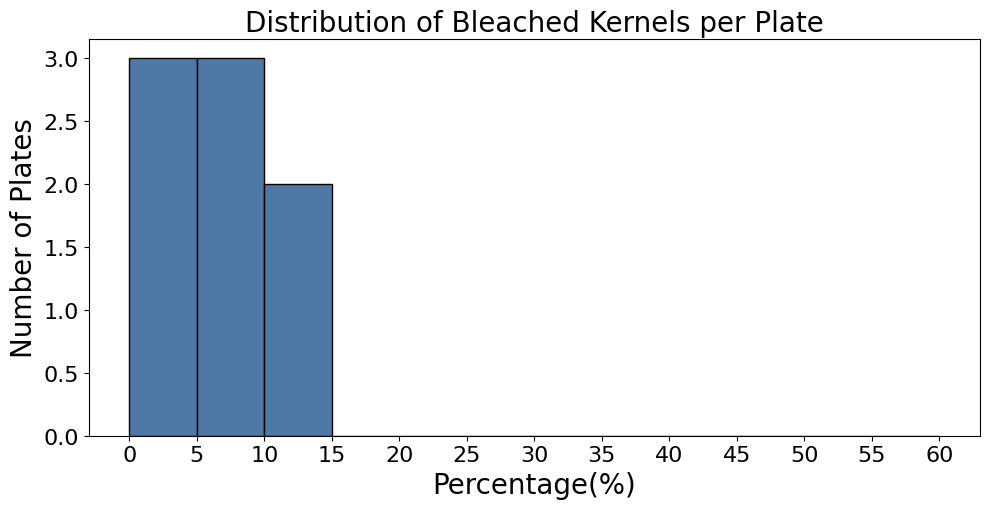

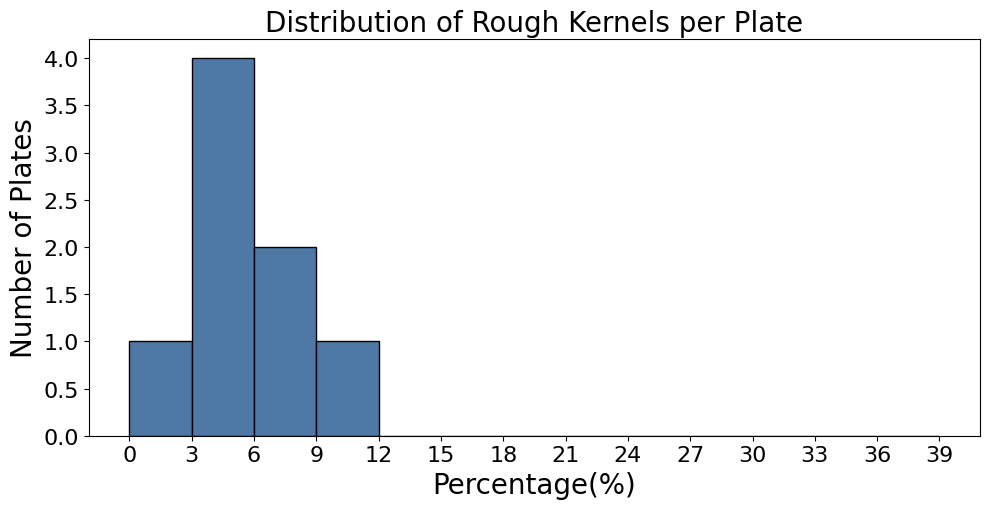

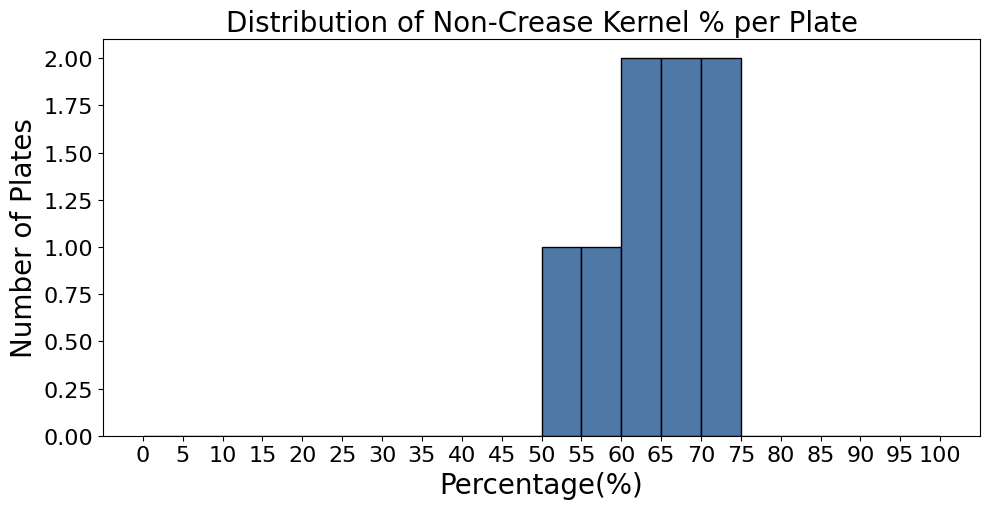

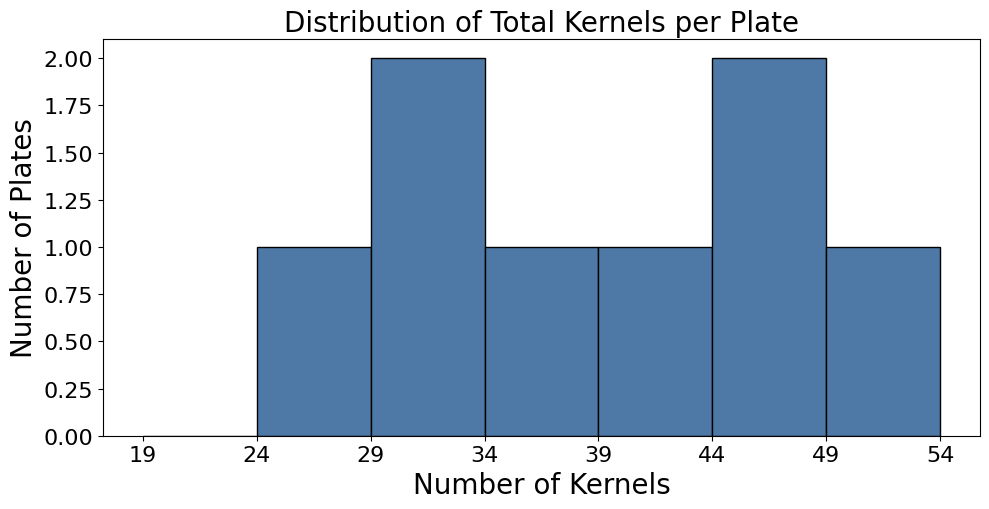

In [5]:
import matplotlib.pyplot as plt


# 1. Average Intensity > 180 %
bins_avg = np.arange(0, 65, 5)
plt.figure(figsize=(10, 5.2))
plt.hist(pct_avg_list, bins=bins_avg, edgecolor='black', color='#4e79a7')
plt.title("Distribution of Bleached Kernels per Plate", fontsize=20)
plt.xlabel("Percentage(%)", fontsize=20)
plt.ylabel("Number of Plates", fontsize=20)
plt.xticks(bins_avg, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

# 2. Std Dev > 65
bins_std = np.arange(0, 40, 3)
plt.figure(figsize=(10, 5.2))
plt.hist(pct_std_list, bins=bins_std, edgecolor='black', color='#4e79a7')
plt.title("Distribution of Rough Kernels per Plate", fontsize=20)
plt.xlabel("Percentage(%)", fontsize=20)
plt.ylabel("Number of Plates", fontsize=20)
plt.xticks(bins_std, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

# 3. Non-Crease Kernel Percentage
bins_noncrease = np.arange(0, 105, 5)
plt.figure(figsize=(10, 5.2))
plt.hist(noncrease_pct_list, bins=bins_noncrease, edgecolor='black', color='#4e79a7')
plt.title("Distribution of Non-Crease Kernel % per Plate", fontsize=20)
plt.xlabel("Percentage(%)", fontsize=20)
plt.ylabel("Number of Plates", fontsize=20)
plt.xticks(bins_noncrease, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

# 4. Total Kernels per Plate
bins_k = np.arange(0, 105, 5)
min_k = min(num_list)
max_k = max(num_list)
bins_k = np.arange(min_k - 5, max_k + 10, 5)

plt.figure(figsize=(10, 5.2))
plt.hist(num_list, bins=bins_k, edgecolor='black', color='#4e79a7')
plt.title("Distribution of Total Kernels per Plate", fontsize=20)
plt.xlabel("Number of Kernels", fontsize=20)
plt.ylabel("Number of Plates", fontsize=20)
plt.xticks(bins_k, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()
